#Experiment 2: Logistic Regression + Reweighing

####Train on LendingClub, Validate on GermanCredit & GiveMeSomeCredit

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
#Step 0: Setup Environment

# Install required libraries
!pip install aif360 shap scikit-learn pandas matplotlib seaborn --quiet

# Imports
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
import shap
import matplotlib.pyplot as plt

from aif360.datasets import StandardDataset
from aif360.algorithms.preprocessing import Reweighing
from aif360.metrics import ClassificationMetric

In [15]:
#Step 1: Load and Preprocess LendingClub Dataset

# Load dataset
df = pd.read_csv('/content/drive/MyDrive/Research_Thesis_Implementation/data_final/lendingclub_data.csv')

# Select relevant columns
selected_cols = ['loan_status','annual_inc','term','grade','home_ownership','purpose','zip_code']
df = df[selected_cols].dropna()

# Convert target to binary
df['loan_status'] = df['loan_status'].apply(lambda x: 1 if x == 'Fully Paid' else 0)

# Encode categoricals
for col in ['term','grade','home_ownership','purpose','zip_code']:
    df[col] = LabelEncoder().fit_transform(df[col].astype(str))

# Normalize income
df['annual_inc'] = StandardScaler().fit_transform(df[['annual_inc']])


/tmp/ipython-input-2829596657.py:4: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/MyDrive/Research_Thesis_Implementation/data_final/lendingclub_data.csv')


In [16]:
#Step 2: Create AIF360 Dataset

# Define privileged/unprivileged groups (zip_code proxy)
privileged_groups = [{'zip_code':1}]
unprivileged_groups = [{'zip_code':0}]

aif_data = StandardDataset(df,
                           label_name='loan_status',
                           favorable_classes=[1],
                           protected_attribute_names=['zip_code'],
                           privileged_classes=[[1]])

In [17]:
# Step 3: Apply Reweighing
RW = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)
aif_data_transf = RW.fit_transform(aif_data)


In [18]:
#Step 4: Train Weighted Logistic Regression

X = aif_data_transf.features
y = aif_data_transf.labels.ravel()
weights = aif_data_transf.instance_weights

clf = LogisticRegression(max_iter=1000)
clf.fit(X, y, sample_weight=weights)

y_pred = clf.predict(X)
y_prob = clf.predict_proba(X)[:,1]

In [19]:
#Step 5: Evaluate Performance & Fairness (LendingClub)
print("\n=== LendingClub (Reweighing) ===")
print("Accuracy:", accuracy_score(y, y_pred))
print("Precision:", precision_score(y, y_pred))
print("Recall:", recall_score(y, y_pred))
print("F1:", f1_score(y, y_pred))
print("AUC-ROC:", roc_auc_score(y, y_prob))

pred_dataset = aif_data.copy()
pred_dataset.labels = y_pred.reshape(-1,1)

metric = ClassificationMetric(aif_data, pred_dataset,
                              unprivileged_groups=unprivileged_groups,
                              privileged_groups=privileged_groups)

print("SPD:", metric.statistical_parity_difference())
print("DI:", metric.disparate_impact())
print("EOD:", metric.equal_opportunity_difference())
print("AOD:", metric.average_odds_difference())
print("BiasAmp:", metric.between_group_generalized_entropy_index())
print("Theil:", metric.theil_index())


=== LendingClub (Reweighing) ===
Accuracy: 0.7756
Precision: 0.8282432785173584
Recall: 0.8724223260929337
F1: 0.8497589716122121
AUC-ROC: 0.7980417898621226
SPD: -0.07692307692307687
DI: 0.9230769230769231
EOD: -0.08333333333333337
AOD: -0.041666666666666685
BiasAmp: 170.3984375
Theil: 0.13755599588528183


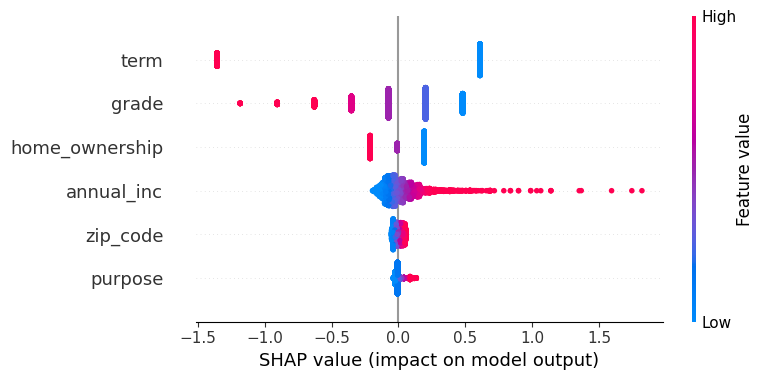

In [20]:
#Step 6: SHAP Explainability

explainer = shap.LinearExplainer(clf, X)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, pd.DataFrame(X, columns=aif_data.feature_names))


=== GermanCredit Validation ===
Accuracy: 0.324
Precision: 0.9
Recall: 0.03857142857142857
F1: 0.07397260273972603
AUC-ROC: 0.5408523809523809


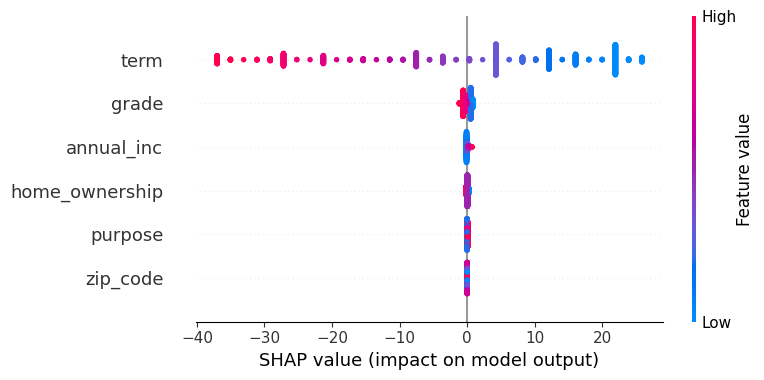

In [25]:
# Step 7: Validation on GermanCredit (schema aligned)

GC_PATH = '/content/drive/MyDrive/Research_Thesis_Implementation/Validation files & results/Validation dataset/german_credit_data.csv'
df_gc = pd.read_csv(GC_PATH)

# --- Target column ---
if 'Risk' in df_gc.columns:
    df_gc['loan_status'] = df_gc['Risk'].map({'good':1,'bad':0})
elif 'Creditability' in df_gc.columns:
    df_gc['loan_status'] = df_gc['Creditability']
elif 'class' in df_gc.columns:
    df_gc['loan_status'] = df_gc['class'].map({'good':1,'bad':0})

# --- Map into LendingClub schema ---
common_gc = pd.DataFrame()
common_gc['annual_inc']     = df_gc['Credit amount']          # proxy for income
common_gc['term']           = df_gc['Duration']               # proxy for term
common_gc['grade']          = df_gc['Purpose']                # proxy for grade
common_gc['home_ownership'] = df_gc['Housing']                # proxy for home_ownership
common_gc['purpose']        = df_gc['Purpose']                # proxy for purpose
common_gc['zip_code']       = df_gc['Checking account']       # proxy for zip_code
common_gc['loan_status']    = df_gc['loan_status']

# --- Encode categoricals ---
for col in ['term','grade','home_ownership','purpose','zip_code']:
    common_gc[col] = LabelEncoder().fit_transform(common_gc[col].astype(str))

# --- Scale income ---
common_gc['annual_inc'] = StandardScaler().fit_transform(common_gc[['annual_inc']])

# --- Features and labels ---
X_gc = common_gc.drop(columns=['loan_status']).values
y_gc = common_gc['loan_status'].values

# --- Predict ---
y_pred_gc = clf.predict(X_gc)
y_prob_gc = clf.predict_proba(X_gc)[:,1]

print("\n=== GermanCredit Validation ===")
print("Accuracy:", accuracy_score(y_gc, y_pred_gc))
print("Precision:", precision_score(y_gc, y_pred_gc))
print("Recall:", recall_score(y_gc, y_pred_gc))
print("F1:", f1_score(y_gc, y_pred_gc))
print("AUC-ROC:", roc_auc_score(y_gc, y_prob_gc))

# --- SHAP Explainability ---
explainer_gc = shap.LinearExplainer(clf, X_gc)
shap_values_gc = explainer_gc.shap_values(X_gc)
shap.summary_plot(shap_values_gc, pd.DataFrame(X_gc, columns=['annual_inc','term','grade','home_ownership','purpose','zip_code']))


=== GiveMeSomeCredit Validation ===
Accuracy: 0.09487333333333334
Precision: 0.8787605836786164
Recall: 0.03484932916112993
F1: 0.06704002748668614
AUC-ROC: 0.46074854135445426


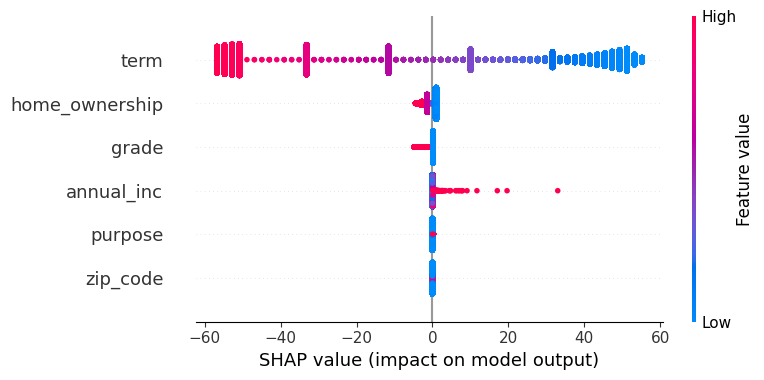

In [27]:
# Step 8: Validation on GiveMeSomeCredit (schema aligned)

GMSC_PATH = '/content/drive/MyDrive/Research_Thesis_Implementation/Validation files & results/Validation dataset/GiveMeSomeCredit.csv'
df_gmsc = pd.read_csv(GMSC_PATH)

# Target: SeriousDlqin2yrs (1=default, 0=no default)
df_gmsc['loan_status'] = 1 - df_gmsc['SeriousDlqin2yrs']

# --- Map into LendingClub schema ---
common_gmsc = pd.DataFrame()
common_gmsc['annual_inc']     = df_gmsc['MonthlyIncome'].fillna(df_gmsc['MonthlyIncome'].median())  # proxy for income
common_gmsc['term']           = df_gmsc['NumberOfOpenCreditLinesAndLoans']                          # proxy for term
common_gmsc['grade']          = df_gmsc['NumberOfTimes90DaysLate']                                  # proxy for grade
common_gmsc['home_ownership'] = df_gmsc['NumberRealEstateLoansOrLines']                             # proxy for home_ownership
common_gmsc['purpose']        = df_gmsc['NumberOfTime30-59DaysPastDueNotWorse']                     # proxy for purpose
common_gmsc['zip_code']       = df_gmsc['NumberOfDependents'].fillna(0)                             # proxy for zip_code
common_gmsc['loan_status']    = df_gmsc['loan_status']

# --- Encode categoricals ---
for col in ['term','grade','home_ownership','purpose','zip_code']:
    common_gmsc[col] = LabelEncoder().fit_transform(common_gmsc[col].astype(str))

# --- Scale income ---
common_gmsc['annual_inc'] = StandardScaler().fit_transform(common_gmsc[['annual_inc']])

# --- Features and labels ---
X_gmsc = common_gmsc.drop(columns=['loan_status']).values
y_gmsc = common_gmsc['loan_status'].values

# --- Predict using LendingClub-trained model ---
y_pred_gmsc = clf.predict(X_gmsc)
y_prob_gmsc = clf.predict_proba(X_gmsc)[:,1]

print("\n=== GiveMeSomeCredit Validation ===")
print("Accuracy:", accuracy_score(y_gmsc, y_pred_gmsc))
print("Precision:", precision_score(y_gmsc, y_pred_gmsc))
print("Recall:", recall_score(y_gmsc, y_pred_gmsc))
print("F1:", f1_score(y_gmsc, y_pred_gmsc))
print("AUC-ROC:", roc_auc_score(y_gmsc, y_prob_gmsc))

# --- SHAP Explainability ---
explainer_gmsc = shap.LinearExplainer(clf, X_gmsc)
shap_values_gmsc = explainer_gmsc.shap_values(X_gmsc)
shap.summary_plot(shap_values_gmsc, pd.DataFrame(X_gmsc, columns=['annual_inc','term','grade','home_ownership','purpose','zip_code']))

In [30]:
# Step 9: Save Validation Results for GermanCredit and GiveMeSomeCredit

RESULTS_DIR = '/content/drive/MyDrive/Research_Thesis_Implementation/Validation files & results/Validation Results _germanCredit &GivemesomeCredit'

# --- Collect results from Step 7 (GermanCredit) ---
results_gc = {
    'Dataset': 'GermanCredit',
    'Accuracy': accuracy_score(y_gc, y_pred_gc),
    'Precision': precision_score(y_gc, y_pred_gc),
    'Recall': recall_score(y_gc, y_pred_gc),
    'F1': f1_score(y_gc, y_pred_gc),
    'AUC': roc_auc_score(y_gc, y_prob_gc)
}

# --- Collect results from Step 8 (GiveMeSomeCredit) ---
results_gmsc = {
    'Dataset': 'GiveMeSomeCredit',
    'Accuracy': accuracy_score(y_gmsc, y_pred_gmsc),
    'Precision': precision_score(y_gmsc, y_pred_gmsc),
    'Recall': recall_score(y_gmsc, y_pred_gmsc),
    'F1': f1_score(y_gmsc, y_pred_gmsc),
    'AUC': roc_auc_score(y_gmsc, y_prob_gmsc)
}

# --- Combine into one DataFrame ---
results_df = pd.DataFrame([results_gc, results_gmsc])

# --- Save to CSV ---
results_df.to_csv(f"{RESULTS_DIR}/validation_results_gc_gmsc.csv", index=False)

print(f"Validation results saved to {RESULTS_DIR}/validation_results_gc_gmsc.csv")

Validation results saved to /content/drive/MyDrive/Research_Thesis_Implementation/Validation files & results/Validation Results _germanCredit &GivemesomeCredit/validation_results_gc_gmsc.csv
